In [16]:
from skyfield.api import EarthSatellite
from skyfield.api import load, wgs84
import numpy as np
import requests
import matplotlib.pyplot as plt
from astroquery.jplhorizons import Horizons
import datetime
import ephem

from astropy.time import Time
from astropy import units as u

import spiceypy as sp

In [17]:
# seconds in a day
secperday = 86400
rearthkm = 6370
mu = 398600 #Earth gravitational parameter in km^3/s^2

#This is the skyfield implementation
ts = load.timescale()
eph = load('de430.bsp')

In [18]:
# Name of the object as apparent in TLE files (CelesTrak)
name = 'ISS'
# Observer latitude (N) in degrees
latitude = 40.1164
# Observer longitude (E) in degrees
longitude = -88.2434
# Observer elevation (m)
elevation = 233
# Start Time, Stop Time and time step of ephemeris output in Julian Date (UT1)

tme = Time('2023-05-21T14:53:0.0',scale='utc')

dt=24/24
#dt=1/86400
jdstart = tme.jd-dt
jdstop = jdstart+dt
jdstep = 1/86400*60*2
#jdstep=1/86400

In [19]:
def get_ephemeris_by_name(name, latitude, longitude, elevation, julian_date):
    '''
    Returns the Right Ascension and Declination relative to the observer's coordinates
    for the given satellite's Two Line Element Data Set at inputted Julian Date.

    **Please note, for the most accurate results, an inputted Julian Date close to the TLE epoch is necessary.

    Parameters
    ---------
    name: 'str'
        CelesTrak name of object
    latitude: 'float'
        The observers latitude coordinate (positive value represents north, negative value represents south)
    longitude: 'float'
        The observers longitude coordinate (positive value represents east, negative value represents west)
    elevation: 'float'
        Elevation in meters
    julian_date: 'float'
        UT1 Universal Time Julian Date. An input of 0 will use the TLE epoch.
    tleapi: 'str'
        base API for query

    Returns
    -------
    Name: 'str'
        The name of the query object
    JulianDate: 'float' or list of 'float'
        UT1 Universal Time Julian Date. 
    Right Ascension: 'float'
        The right ascension of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,360)
    Declination: 'float'
        The declination of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [-90,90]
    Altitude: 'float'
        The altitude of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,90]
    Azimuth: 'float'
        The azimuth of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,360)
    Range: 'float'
        Range to object in km
    '''

#    tleLine1, tleLine2 = getTLE(name)
    #ISS (ZARYA)             
    #tleLine1='1 25544U 98067A   23107.71565398  .00019656  00000+0  35236-3 0  9995' 
    #tleLine2='2 25544  51.6394 268.2146 0006096 203.2981 157.3069 15.49919092392414'
    # #tle = '1 25544U 98067A   23050.90915690  .00019097  00000+0  33852-3 0  9998 2 25544  51.6393 189.4175 0009582   7.6791  73.9158 15.50232555383604'
    tleLine1='1 25544U 98067A   23244.52812118  .00012864  00000-0  23190-3 0  9992'
    tleLine2='2 25544  51.6432 310.3513 0005071  22.2661  10.6871 15.50130603413635'

    #Cast the latitude, longitude, and jd to floats (request parses as a string)
    lat = float(latitude)
    lon = float(longitude)
    ele = float(elevation)
    
    # Converting string to list
    jul = str(julian_date).replace("%20", ' ').strip('][').split(', ')
   
    # Converting list elements to float
    jd = [float(i) for i in jul]
   
    #    # return {'jd':jd , "TLELine1":tleLine1, "TLELine2":tleLine2 } 
#    # propagation and create output
#    resultList = []
#    for d in jd:
#        [ra,dec,alt,az,r] = propagateSatellite(tleLine1,tleLine2,lat,lon,ele,d)
#        resultList.append(jsonOutput(name,d,ra,dec,alt,az,r)) 
#    return resultList

    if(len(jd)>1000):
        raise InvalidAPIUsage("Too many entries requested!",status_code=402)   

    # return {'jd':jd , "TLELine1":tleLine1, "TLELine2":tleLine2 } 
    # propagation of satellite position and creation of output
    resultList = []
    for d in jd:
        #Right ascension RA (deg), Declination Dec (deg), dRA/dt*cos(Dec) (deg/day), dDec/dt (deg/day),
        # Altitude (deg), Azimuth (deg), dAlt/dt (deg/day), dAz/dt (deg/day), distance (km), range rate (km/s), phaseangle(deg), illuminated (T/F)   
        [ra, dec, dracosdec, ddec, alt, az, 
         #dalt, daz, 
         r, dr, phaseangle, illuminated] = propagateSatellite(tleLine1,tleLine2,lat,lon,ele,d)
        
        resultList.append([name, d, ra._degrees, dec.degrees, dracosdec, ddec,
                                     alt.degrees, az.degrees, 
                                     #dalt*secperday, daz*secperday, 
                                     r.km, dr, phaseangle, illuminated]) 
    return resultList

In [20]:
def getTLE(targetName, tleapi='https://celestrak.org/NORAD/elements/gp.php?NAME='):
    """
    Query Two Line Element (orbital element) API and return TLE lines for propagation
    
    Paremeters:
    ------------
    targetName: 'str'
        Name of satellite as displayed in TLE file
    tleapi: 'str'
        URL of TLE API
        
        
    Returns:
    --------
    tleLine1: 'str'
        TLE line 1
    tleLine2: 'str'
        TLE line 2
    """

    # uncomment if json output is required
    #tleapiResult=requests.get(f'{tleapi}{targetName}&FORMAT=JSON').json()	    

    # we will go with the standard TLE format here
    tleapiResult=requests.get(f'{tleapi}{targetName}&FORMAT=TLE')
    
    tle = tleapiResult.text.replace("%20", ' ')
    #Retrieve the two lines
    tleLine1 = tle[26:95]
    tleLine2 = tle[97:166]

    return tleLine1, tleLine2


def propagateSatellite(tleLine1, tleLine2, lat, lon, elevation, jd, dtsec=1):
    """Use Skyfield (https://rhodesmill.org/skyfield/earth-satellites.html) 
     to propagate satellite and observer states.
     
     Parameters
    ---------
    tleLine1: 'str'
        TLE line 1
    tleLine2: 'str'
         TLE line 2
    lat: 'float'
        The observer WGS84 latitude in degrees
    lon: 'float'
        The observers WGS84 longitude in degrees (positive value represents east, negatie value represents west)
    elevation: 'float'
        The observer elevation above WGS84 ellipsoid in meters
    julian_date: 'float'
        UT1 Universal Time Julian Date. An input of 0 will use the TLE epoch.
    tleapi: 'str'
        base API for query

    Returns
    -------
    Right Ascension: 'float'
        The right ascension of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,360)
    Declination: 'float'
        The declination of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [-90,90]
    Altitude: 'float'
        The altitude of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,90]
    Azimuth: 'float'
        The azimuth of the satellite relative to observer coordinates in ICRS reference frame in degrees. Range of response is [0,360)
    distance: 'float'
        Range from observer to object in km
    """
        

    ts = load.timescale()
    satellite = EarthSatellite(tleLine1,tleLine2,ts = ts)

    #Get current position and find topocentric ra and dec
    currPos = wgs84.latlon(lat, lon, elevation)
    # Set time to satellite epoch if input jd is 0, otherwise time is inputted jd
    if jd == 0: t = ts.ut1_jd(satellite.model.jdsatepoch)
    else: t = ts.ut1_jd(jd)

    difference = satellite - currPos
    topocentric = difference.at(t)
    topocentricn = topocentric.position.km/np.linalg.norm(topocentric.position.km)
    
    ra, dec, distance = topocentric.radec()
    alt, az, distance = topocentric.altaz()
    
    dtday=dtsec/secperday
    tplusdt = ts.ut1_jd(jd+dtday)
    tminusdt = ts.ut1_jd(jd-dtday)
    
#     vtopo = difference.at(dtplus)-difference.at(dtminus)
#     print(topocentric)
#     print(vtopo)
#     dradt, ddecdt, ddistancedt = vtopo.radec()
    
    dtx2 = 2*dtsec 
    #print(dtx2)
#     dra = dradt.value/dtx2
#     ddec = ddecdt.value/dtx2
#     ddistance = ddistancedt.km/dtx2 
    #print(satellite.at(t).position.km)
    sat = satellite.at(t).position.km
    #print('sat',sat)
    satn = sat/np.linalg.norm(sat)
    satpdt = satellite.at(tplusdt).position.km
    satmdt = satellite.at(tminusdt).position.km
    vsat = (satpdt - satmdt)/dtx2
    #print('vsat',vsat)
    
    sattop = difference.at(t).position.km
    sattopr = np.linalg.norm(sattop)
    sattopn = sattop/sattopr
    sattoppdt = difference.at(tplusdt).position.km
    sattopmdt = difference.at(tminusdt).position.km
    
    ratoppdt,dectoppdt = icrf2radec(sattoppdt)
    ratopmdt,dectopmdt = icrf2radec(sattopmdt)
    
    vsattop = (sattoppdt - sattopmdt)/dtx2
    
    ddistance = np.dot(vsattop,sattopn)
    #print('sattop',sattop)
    #print('vsattop',vsattop)
    #print('vsattop/sattopr',vsattop/sattopr)
    #rxy = np.dot(sattop[0:2],sattop[0:2])
    #dra = (sattop[1]*vsattop[0]-sattop[0]*vsattop[1])/rxy
    #print('x^2+y^2', rxy)
    #ddec = vsattop[2]/np.sqrt(1-sattopn[2]*sattopn[2])
    #dracosdec = dra*np.cos(dec.radians)
    #print('from xyz: dra,ddec,ddistance,dracosdec',[dra,ddec,ddistance,dracosdec])
 
    dra = (ratoppdt - ratopmdt)/dtx2
    ddec = (dectoppdt - dectopmdt)/dtx2
    dracosdec = dra*np.cos(dec.radians)
    #print('from r: dra,ddec,ddistance,dracosdec',[dra,ddec,ddistance,dracosdec])
    
    #dra, ddec = uicrf2radec(vsattop/sattopr)
    #dracosdec = dra*np.cos(dec.radians)
    
    #print('from v: dra,ddec,ddistance,dracosdec',[dra,ddec,ddistance,dracosdec])
    
    
    earth = eph['Earth']
    sun = eph['Sun']
    #print(t,ts.ut1(jd))
    earthp = earth.at(ts.ut1_jd(jd)).position.km
    sunp = sun.at(ts.ut1_jd(jd)).position.km
    earthsun = sunp - earthp
    earthsunn = earthsun/np.linalg.norm(earthsun)
    satsun =  sat - earthsun
    satsunn = satsun/np.linalg.norm(satsun)
    phase_angle = np.rad2deg(np.arccos(np.dot(satsunn,topocentricn)))
    
    #Is the satellite in Earth's Shadow?
    r_parallel = np.dot(sat,earthsunn)*earthsunn
    r_tangential = sat-r_parallel
    
 #   if alt.degrees>0:
  #      print('Satellite is above the horizon')
   # else:
    #    print('Satellite is not above the horizon')
    

    illuminated = True
    
    if(np.linalg.norm(r_parallel)<0): 
        if(np.linalg.norm(r_tangential)<rearthkm):
            #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
            #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
            illuminated = False
    
    return (ra, dec, dracosdec, ddec, alt, az, 
            distance, ddistance, phase_angle, illuminated)


def my_arange(a, b, dr, decimals=11):
    """
    Better arange function that compensates for round-off errors.
    
    Parameters:
    -----------
    a: 'float'
        first element in range 
    b: 'float'
        last element in range
    dr: 'float'
        range increment
    decimals: 'integer'
        post comma digits to be rounded to
        
    Returns:
    --------
    res: 'numpy array of floats'
        array of numbers between a and b with dr increments
    """
    
    res = [a]
    k = 1
    while res[-1] < b:
        tmp = np.round(a + k*dr,decimals)
        if tmp > b:
            break   
        res.append(tmp)
        k+=1

    return np.asarray(res) 

def tle2ICRFstate(tleLine1,tleLine2,jd):

    #This is the skyfield implementation
    ts = load.timescale()
    satellite = EarthSatellite(tleLine1,tleLine2,ts = ts)

    # Set time to satellite epoch if input jd is 0, otherwise time is inputted jd
    if jd == 0: t = ts.ut1_jd(satellite.model.jdsatepoch)
    else: t = ts.ut1_jd(jd)

    r =  satellite.at(t).position.km
    # print(satellite.at(t))
    v = satellite.at(t).velocity.km_per_s
    return np.concatenate(np.array([r,v]))

def jsonOutput(name,time,ra,dec,dracosdec,ddec, 
               alt, az, 
               #dalt, daz, 
               r, dr, phaseangle, illuminated, 
               precisionAngles=11,precisionDate=12,precisionRange=12):
    """
    Convert API output to JSON format
    
    Parameters:
    -----------
    name: 'str'
        Name of the target satellite
    time: 'float'
        Julian Date
    ra: Skyfield object / 'float'
        Right Ascension 
    dec: Skyfield object / 'float'
        Declination
    alt: Skyfield object / 'float'
        Altitude
    az: Skyfield object / 'float'
        Azimuth
    r: Skyfield object / 'float'
        Range to target
    precisionAngles: 'integer'
        number of digits for angles to be rounded to (default: micro arcsec)
    precisionDate: 'integer'
        number of digits for Julian Date to be rounded to (default: micro sec)
    precisionRange: 'integer'
        number of digits for angles to be rounded to (default: nano meters)   
        
    Returns:
    --------
    output: 'dictionary'
        JSON dictionary of the above quantities
    
    """
    
    #looking up the numpy round function once instead of multiple times makes things a little faster
    myRound = np.round
    output= {"NAME": name,
            "JULIAN_DATE": myRound(time,precisionDate),
            "RIGHT_ASCENSION-DEG": myRound(ra._degrees,precisionAngles),
            "DECLINATION-DEG": myRound(dec.degrees,precisionAngles),
            "DRA_COSDEC-DEG_PER_SEC":  myRound(dracosdec,precisionAngles),
            "DDEC-DEG_PER_SEC": myRound(ddec,precisionAngles),
            "ALTITUDE-DEG": myRound(alt.degrees,precisionAngles),
            "AZIMUTH-DEG": myRound(az.degrees,precisionAngles),
            # "DALT-DEG_PER_SEC": myRound(dalt,precisionAngles),
            # "DAZ-DEG_PER_SEC": myRound(daz, precisionAngles),
            "RANGE-KM": myRound(r.km,precisionRange),
            "RANGE_RATE-KM_PER_SEC": myRound(dr,precisionRange),
            "PHASE_ANGLE-DEG": myRound(phaseangle, precisionAngles),
            "ILLUMINATED": illuminated
            } 
    
    return output   


def icrf2radec(pos, deg=True):
    """
    Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec


def uicrf2radec(pos, deg=True):
    """
    Convert ICRF xyz unit vector to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        xu=pos[:,0]
        yu=pos[:,1]
        zu=pos[:,2]
    else:
        xu=pos[0]
        yu=pos[1]
        zu=pos[2]
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [21]:
#observer_location = {'lon': longitude, 'lat': latitude, 'elevation': elevation}  # Replace with your desired coordinates
#obj = Horizons(id='-125544', location=observer_location, epochs={'start': '2023-09-01 00:00:00', 'stop': '2023-09-08 00:00:00', 'step': '15m'})
#eph = obj.ephemerides()
#print(eph

# Reading "NASA_hroizons_data.txt" file which is downloaded from NASA Horizons on 2023 Sept 1  and updated TLE is used
# Data is from 1 sept to 8 sept with 15 min time step
inside =False
f=open("NASA_hroizons_data.txt","r")
books=[]
for x in f:
    if "$$SOE" in x:
        inside=True
    if "$$EOE" in x:
        inside =False
    
    if inside:
       books.append(x)

# In Final all the data stored    
Final=[]
for i in range(1,674):
    a=books[i].split()
    row=[]
    for q in range(len(a)):
        if len(a)==9:
            value=a[q]
            value = float(value)
            row.append(value)
        if len(a)==10:
            if q!=1:
                value=a[q]
                value = float(value)
                row.append(value)
                
    Final.append(row)
    
#Final have data like this [JD,RA,DA,DRACOSDEC,DDEC,AZIMUTH,ALTITUDE,RANGE,RANGERATE]    
JD = [row[0] for row in Final]    
RA = [row[1] for row in Final]
DA = [row[2] for row in Final]  
column3 = [row[3] for row in Final]  # Nasa Horizon Uses arcsec per hr for dracosdec
column3 = np.array(column3)
DRACOSDEC = column3 /(3600*3600)
column4 = [row[4] for row in Final]  # Nasa Horizon Uses arcsec per hr for ddec
column4 = np.array(column4)
DDEC = column4 /(3600*3600)
AZIMUTH = [row[5] for row in Final]  
ALTITUDE = [row[6] for row in Final]
RANGE = [row[7] for row in Final]  
RANGERATE = [row[8] for row in Final]  


In [22]:
ab=get_ephemeris_by_name(name, latitude, longitude, elevation, JD) # smae julian date is used to that of NASA Horizon
#output for ab is [name,jd,ra,da,dracosdec,ddec,altitude,azimuth,range,rangerate]
jd = [row[0+1] for row in ab]
ra = [row[1+1] for row in ab]   
da = [row[2+1] for row in ab]
dracosdec = [row[3+1] for row in ab]  
ddec = [row[4+1] for row in ab]
azimuth = [row[6+1] for row in ab]   
altitude = [row[5+1] for row in ab]
ranges = [row[7+1] for row in ab]   
rangerate = [row[8+1] for row in ab]

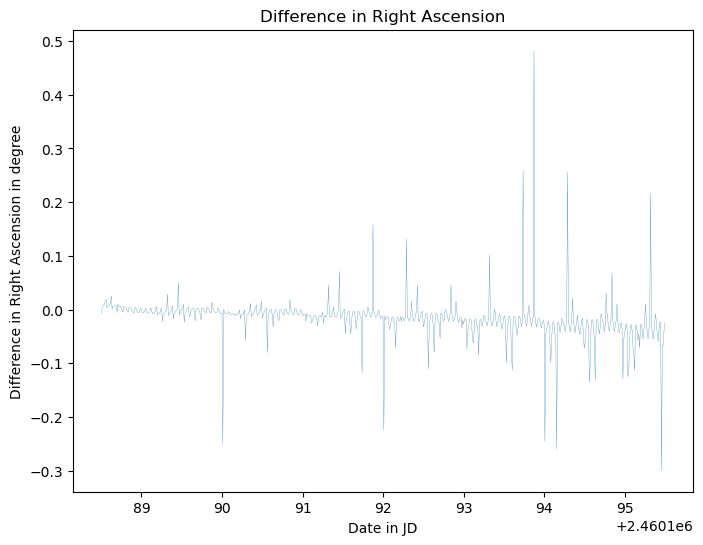

In [23]:
plt.figure(figsize=(8, 6))

column1 = np.array(RA)
col1 = np.array(ra)

# Perform element-wise subtraction
result1 = column1 - col1

plt.plot(JD, result1, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Right Ascension in degree')

# Add a title to the plot
plt.title('Difference in Right Ascension')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Right Ascension.png', dpi=800)

# Display the plot (optional)
plt.show()

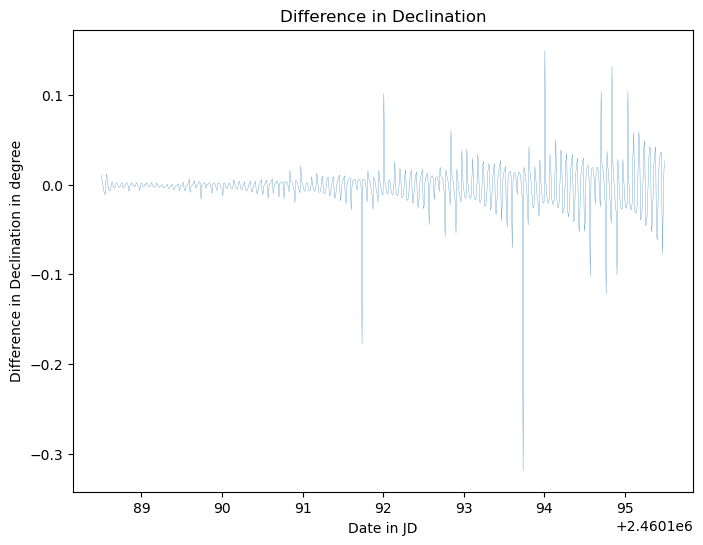

In [24]:
plt.figure(figsize=(8, 6))

column2 = np.array(DA)
col2 = np.array(da)

# Perform element-wise subtraction
result2 = column2 - col2

plt.plot(JD, result2, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Declination in degree')

# Add a title to the plot
plt.title('Difference in Declination')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Declination.png', dpi=800)

# Display the plot (optional)
plt.show()

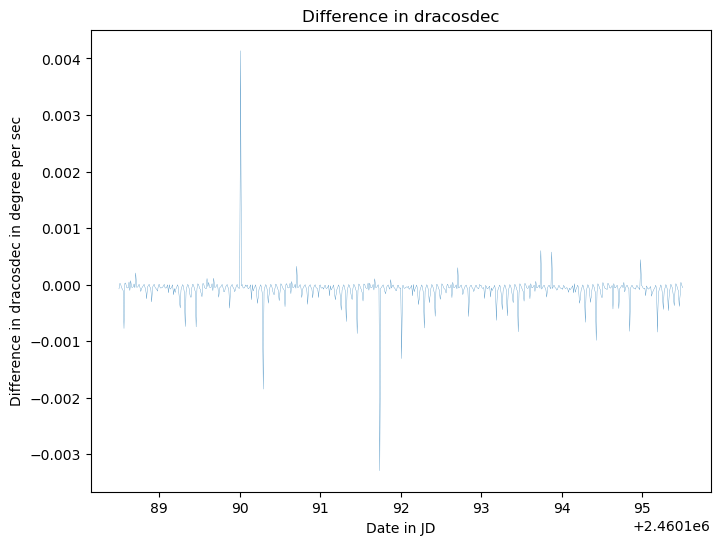

In [25]:
plt.figure(figsize=(8, 6))

column3 = np.array(DRACOSDEC)
col3 = np.array(dracosdec)

# Perform element-wise subtraction
result3 = column3 - col3

plt.plot(JD, result3, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in dracosdec in degree per sec')

# Add a title to the plot
plt.title('Difference in dracosdec')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in dracosdec.png', dpi=800)

# Display the plot (optional)
plt.show()

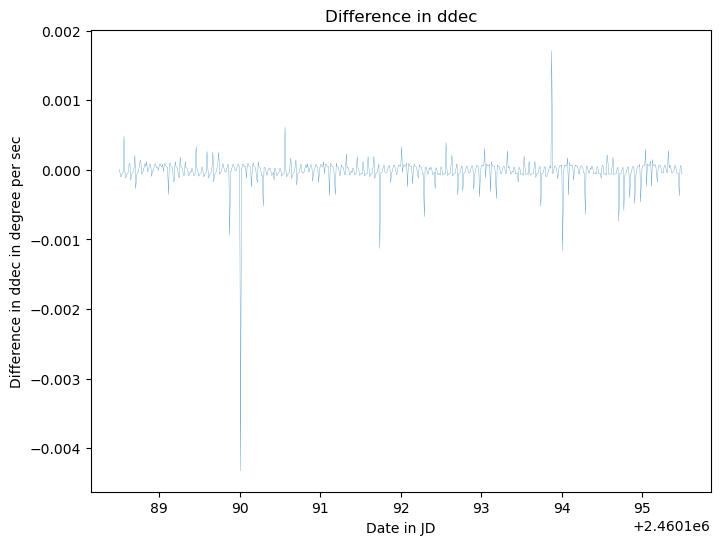

In [26]:
plt.figure(figsize=(8, 6))

column4 = np.array(DDEC)
col4 = np.array(ddec)

# Perform element-wise subtraction
result4 = column4 - col4

plt.plot(JD, result4, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in ddec in degree per sec')

# Add a title to the plot
plt.title('Difference in ddec')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in ddec.png', dpi=800)

# Display the plot (optional)
plt.show()

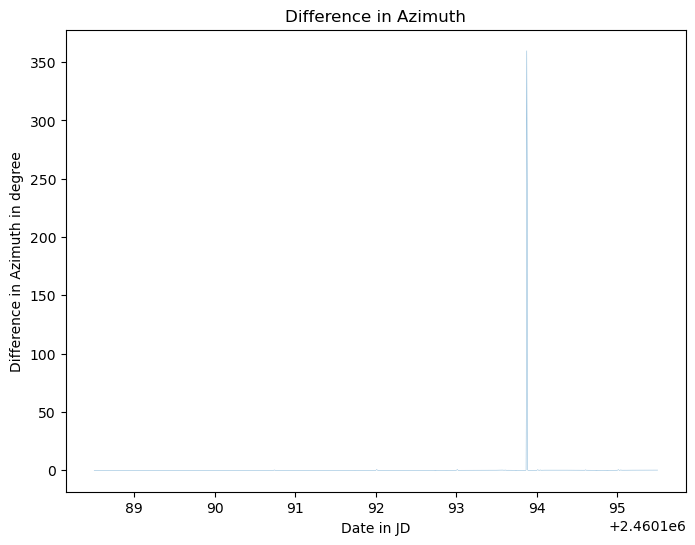

In [27]:
plt.figure(figsize=(8, 6))

column5 = np.array(AZIMUTH)
col5 = np.array(azimuth)

# Perform element-wise subtraction
result5 = column5 - col5

plt.plot(JD, result5, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Azimuth in degree')

# Add a title to the plot
plt.title('Difference in Azimuth')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Azimuth.png', dpi=800)

# Display the plot (optional)
plt.show()

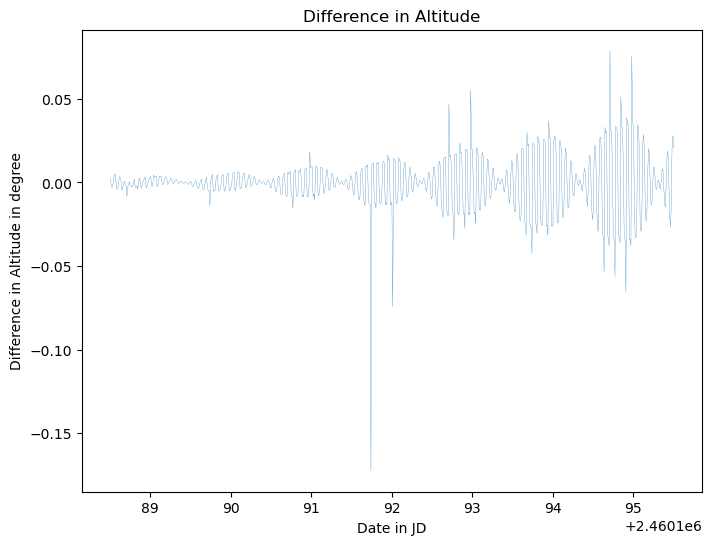

In [28]:
plt.figure(figsize=(8, 6))

column6 = np.array(ALTITUDE)
col6 = np.array(altitude)

# Perform element-wise subtraction
result6 = column6 - col6

plt.plot(JD, result6, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Altitude in degree')

# Add a title to the plot
plt.title('Difference in Altitude')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Altitude.png', dpi=800)

# Display the plot (optional)
plt.show()

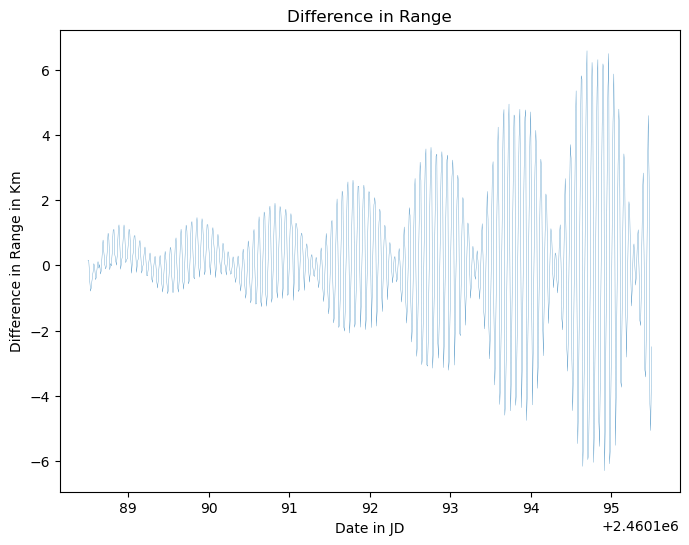

In [29]:
plt.figure(figsize=(8, 6))

column7 = np.array(RANGE)
col7 = np.array(ranges)

# Perform element-wise subtraction
result7 = column7 - col7

plt.plot(JD, result7, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Range in Km')

# Add a title to the plot
plt.title('Difference in Range')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Range.png', dpi=800)

# Display the plot (optional)
plt.show()

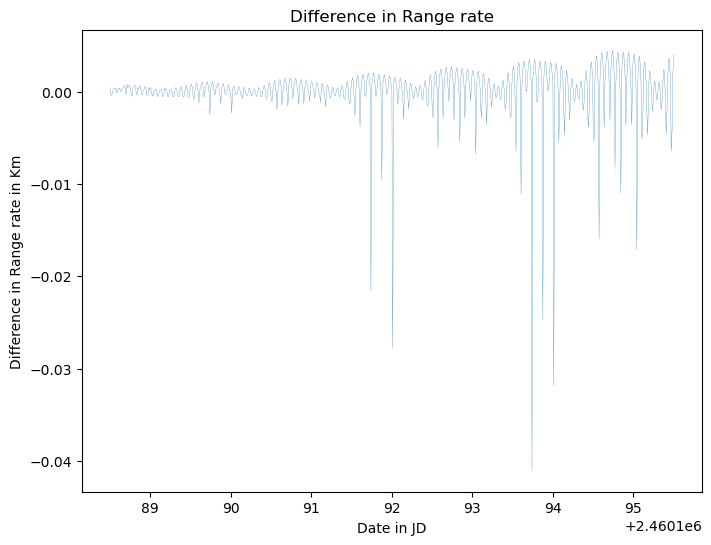

In [30]:
plt.figure(figsize=(8, 6))

column8 = np.array(RANGERATE)
col8 = np.array(rangerate)

# Perform element-wise subtraction
result8 = column8 - col8

plt.plot(JD, result8, linewidth=0.2)


# Add labels for the x-axis and y-axis
plt.xlabel('Date in JD')
plt.ylabel('Difference in Range rate in Km')

# Add a title to the plot
plt.title('Difference in Range rate')

# Add a legend to the plot

# Save the plot as an image with high DPI
plt.savefig('Difference in Range rate.png', dpi=800)

# Display the plot (optional)
plt.show()